# Lab 2 - Comparison with Diffusion Theory
The purpose of this lab is to compare flux and reaction rates computed using MCNP (or OpenMC) with those that you compute using Diffusion Theory.

A mono-energtic point source is located at the center of a sphere of lead.  The spatial flux distribution and reaction rates computed with OpenMC will be compared with the same results from Diffusion Theory.


## Diffusion Theory Results
It is useful to have a good idea of what the expected result will be even before you create your model and begin computation.  

For this lab we will compute and plot diffusion theory results to which we will compare OpenMC tally outputs.

The given data will be the macroscopic cross section for scattering and absorption: $\Sigma_a$ and $\Sigma_s$ respectively; and the average cosine of neutron scattering angle: $\bar{\mu}$.  

From these, the transport mean free path $(\lambda_{tr})$ is computed:
$$\lambda_{tr}=\frac{1}{\Sigma_{tr}}=\frac{1}{\Sigma_s(1-\bar{\mu})}$$

The diffusion coefficient $(D)$:
$$D = \frac{\lambda_{tr}}{3}$$
and, for diffusion theory with vacuum boundary conditions, the extrapolation distance $(d)$ is needed:
$$d=0.71 \lambda_{tr}$$

The diffusion length $(L)$ is also needed which is computed:
$$L = \sqrt{\frac{D}{\Sigma_a}}$$


### Parameters

In [1]:
lead_density = 11.35; # g/cm3
Sigma_a_lead = 5.03e-3; # 1/cm, macroscopic absorption cross section for lead
Sigma_s_lead = 0.3757; # 1/cm
mu_bar = 3.2e-3;


In [2]:
import numpy as np

lam_tr = 1./(Sigma_s_lead*(1.-mu_bar))
D = lam_tr/3.
d = 0.71*lam_tr
L = np.sqrt(D/Sigma_a_lead)

### Analytic Results
For a point source in spherical coordinates, the flux as a functio of position is:
$$\phi(r)=\frac{S \sinh{\left(\frac{R+d-r}{L}\right)}}{4 \pi D r \sinh{\left(\frac{R+d}{L} \right)}}$$
Where $S$ is the source strength (neutrons/s) and $R$ is the radius of the diffusive medium; all other variables as previously defined.

The diffusion theory solution for flux $(\phi(r))$ for this problem is plotted below.

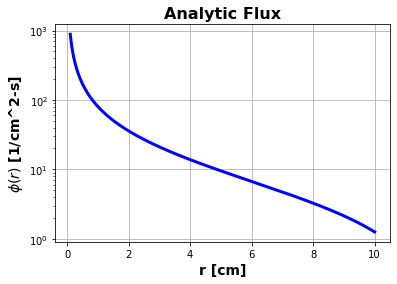

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

S = 1000; #n/sec, source strength
R = 10; # cm, lead diffusive medium radius

def analytic_flux(r):
    return S*np.sinh((R+d-r)/(L))/(4.*np.pi*D*r*np.sinh((R+d)/L))
    
r = np.linspace(1e-1,R,1000)
phi = analytic_flux(r)
analytic_sol = plt.semilogy(r,phi);
plt.setp(analytic_sol,'color','b','linewidth',3);
plt.xlabel('r [cm]',fontsize=14,fontweight='bold');
plt.ylabel('$\phi(r)$ [1/cm^2-s]',fontsize=14,fontweight='bold');
plt.grid(True);
plt.title('Analytic Flux',fontsize=16,fontweight='bold');

The lab also asks the students to compute the rate of neutron absorption.  Accounting for angular symmetry and assuming constant material properties, the absorption rate should be:
$$\text{Absorption Rate } = 4 \pi \Sigma_a \int_0^R \phi(r) r^2 \ dr$$

In [4]:
import scipy.integrate as integrate

abs_rate,err_bnd = integrate.quad(lambda r: analytic_flux(r)*(r**2),
                    0,R)
abs_rate = 4.*np.pi*Sigma_a_lead*abs_rate
print(f'Diffusion Theory Absorption rate: {abs_rate:4.3f} per second')


Diffusion Theory Absorption rate: 113.834 per second


## OpenMC Model

In [5]:
import openmc

## Materials

For this lab, the only material we need is lead. We will enter this by nuclide so students can get practice with the interface.

In [6]:
lead = openmc.Material(name='lead')
lead.add_nuclide('Pb204',0.014)
lead.add_nuclide('Pb206',0.241)
lead.add_nuclide('Pb207',0.221)
lead.add_nuclide('Pb208',0.524)
lead.set_density('g/cm3',11.35)


Alternatively, the lead could have been added elementally

In [7]:
lead = openmc.Material(name='lead')
lead.add_element('Pb',1.0)
lead.set_density('g/cm3',11.35)
# if I had the correct atom densities in the box above, these *should* 
# be equivalent.

mf = openmc.Materials([lead])
mf.export_to_xml()

## Geometry
For a simple geometric domain, I will have a sphere of lead surrounded by a void.  

In [8]:
sphere_rad = 10.; # cm, radius of sphere
sphere = openmc.Sphere(r=sphere_rad)
outside = openmc.Sphere(r=1.5*sphere_rad,boundary_type='vacuum')


lead_sphere = openmc.Cell()
lead_sphere.fill = lead
lead_sphere.region = -sphere

outside_void = openmc.Cell()
outside_void.fill = None
outside_void.region = +sphere & -outside

root = openmc.Universe()
root.add_cells([lead_sphere,outside_void])

g = openmc.Geometry()
g.root_universe = root
g.export_to_xml()


## Tallies
For this lab, tallies are needed for the following values:
<ol>
    <li>neutron absorption rate in the lead sphere </li>
    <li>flux as a function of radius (out to the extrapolated radius) </li>
</ol>

In [9]:
tallies = openmc.Tallies() # object to hold all tallies

sphere_filter = openmc.CellFilter(lead_sphere.id)
t = openmc.Tally(name='abs_tally')
t.filters = [sphere_filter]
t.scores = ['absorption']

tallies.append(t)

regMesh = openmc.RegularMesh()
meshDim = 31
regMesh.dimension = (meshDim,meshDim)
regMesh.lower_left = (0,0)
regMesh.upper_right = (R,R)

mesh_filt = openmc.MeshFilter(regMesh)

t = openmc.Tally(name='flux_tally')
t.filters = [mesh_filt]
t.scores = ['flux']
tallies.append(t)


tallies.export_to_xml()

## Settings
This is another fixed-source problem much like lab 1

In [10]:
settings = openmc.Settings()
settings.run_mode = 'fixed source'
settings.batches = 50
settings.particles = 1000000

source = openmc.Source()
source.particle = 'neutron'
source.space = openmc.stats.Point(xyz=(0.,0.,0.))
source.angle = openmc.stats.Isotropic();
source.energy = openmc.stats.Discrete([0.0253],[1.0]) #0.0253 eV source
source.strength = S


settings.source = source;

settings.export_to_xml()

In [11]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Check Results
Now we will open the statepoint file and analyze the results

In [12]:
sp = openmc.StatePoint('statepoint.50.h5')
abs_tally = sp.get_tally(name='abs_tally')
df = abs_tally.get_pandas_dataframe()
df.head(1)

,cell,nuclide,score,mean,std. dev.
0,1,total,absorption,137.853062,0.011888


In [13]:
abs_rate_omc = df['mean'][0] # there must be a better way
print(f'Absorption Rate from OpenMC: {abs_rate_omc:6.3f} per second.')


Absorption Rate from OpenMC: 137.853 per second.


In [14]:
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	abs_tally
 	Filters        =	CellFilter
 	Nuclides       =	total
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 2: Tally
 	ID             =	2
 	Name           =	flux_tally
 	Filters        =	MeshFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength}

In [15]:
flux_tally = sp.get_tally(name='flux_tally')
df_flux = flux_tally.get_pandas_dataframe()
df_flux.head()

mesh 1       nuclide score        mean std. dev.
       x  y  z                                    
0      1  1  1   total  flux  178.956933  0.042830
1      2  1  1   total  flux   80.973944  0.029322
2      3  1  1   total  flux   56.294542  0.027579
3      4  1  1   total  flux   44.054779  0.022515
4      5  1  1   total  flux   36.462107  0.018232

In [16]:
df_flux.max()

mesh 1     x            31
           y            31
           z             1
nuclide              total
score                 flux
mean            178.956933
std. dev.          0.04283
dtype: object

In [17]:
df_flux['mean'].max()

178.95693266796678

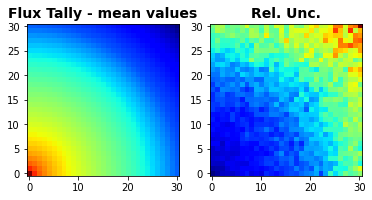

In [18]:
from matplotlib.colors import LogNorm # so I can use log of tally value

fluxes = df_flux['mean'].values
rel_err = df_flux['std. dev.'].values / fluxes

Xs = df_flux['mesh 1']['x'].values
Ys = df_flux['mesh 1']['y'].values
fluxes.shape = (meshDim,meshDim)
rel_err.shape = (meshDim,meshDim)

#fluxes = fluxes.T
#rel_err = rel_err.T

Xs.shape = (meshDim,meshDim)
Ys.shape = (meshDim,meshDim)

fig = plt.subplot(121)

plt.imshow(fluxes,interpolation='none',norm=LogNorm(),cmap='jet');
plt.grid(False);
plt.ylim(plt.ylim()[::-1]) #invert the y-axis
plt.title('Flux Tally - mean values',fontsize=14,fontweight='bold');
#plt.colorbar();

fig2 = plt.subplot(122)
plt.imshow(rel_err,interpolation='none',cmap='jet');
plt.ylim(plt.ylim()[::-1]);
plt.title('Rel. Unc.',fontsize=14,fontweight='bold');
plt.grid(False);
#plt.colorbar();


Note that the relative uncertainty increases as you move further from the source.  *(take a moment to consider how weird this is in the context of other numerical algorithms in scientific computing)* This is a statistical reality when using Monte Carlo Methods.  The issue is that fewer particles travel that far from the source and, as a consequence, there are fewer "scoring" opportunities with those tally sites.  A large part of the theory and practical toolset of a Monte Carlo code has the aim of addressing this problem.

In [19]:
fluxes[int(meshDim/2),int(meshDim/2)]

5.296606954618589

In [20]:
fluxes.max()

178.95693266796678

In [21]:
fluxes.min()

0.4338854578966431

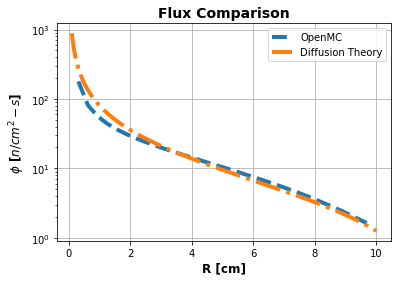

In [26]:
flux_profile = fluxes[0,:]
X_ord = Xs[0,:]
X_ord = X_ord*(R/(meshDim+1))
plt.semilogy(X_ord,flux_profile,label='OpenMC',linestyle='--',
            linewidth=4);
plt.semilogy(r,phi,label='Diffusion Theory',linestyle='-.',
             linewidth=4);
plt.xlabel('R [cm]',fontsize=12,fontweight='bold')
plt.ylabel('$\phi$ [$n/cm^2-s$]',fontsize=12,fontweight='bold')
plt.legend();
plt.grid(True);
plt.title('Flux Comparison',fontsize=14,fontweight='bold');